# Demo for Hydrogen Uptake Conditinoing

In [1]:
# Designate GPU to use
import os
gpu_ids = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_ids}"

In [2]:
# import libraries
import numpy as np
from PIL import Image
from pathlib import Path
from IPython.display import Image as ipy_image
from IPython.display import display
from termcolor import colored, cprint

import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import torchvision.utils as vutils
import torch.nn.functional as F

from collections import OrderedDict
from models.base_model import create_model
from utils.util_3d import render_sdf, render_mesh, sdf_to_mesh, save_mesh_as_gif
from utils.build_materials import build_materials
from utils.pormake_serialize import serialize
from sklearn.preprocessing import LabelEncoder
import joblib

from visualize.visualizer import MOFVisualizer, animate, resize_gif, make_concat_gif
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import glob
import os

import warnings
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

%load_ext autoreload
%autoreload 2

>>> Console logs (under WARNING level) are disabled.
>>> Console logs (under WARNING level) are disabled.


In [3]:
# options for the model. please check `utils/demo_util.py` for more details
from utils.demo_util import MOFFUSIONH2Opt

seed = 1
opt = MOFFUSIONH2Opt(gpu_ids=gpu_ids, seed=seed)
device = opt.device

[*] MOFFUSION-H2-Option initialized.


In [4]:
# Initialize MOFFUSION-H2 model
ckpt_path = 'saved_ckpt/moffusion_H2.pth'

opt.init_model_args(ckpt_path=ckpt_path)
MOFFUSION = create_model(opt)
cprint(f'[*] "{MOFFUSION.name()}" loaded.', 'cyan')

[*] VQVAE: weight successfully load from: ./saved_ckpt/vqvae.pth
[*] weight successfully load from: saved_ckpt/moffusion_H2.pth
[*] setting ddim_steps=200
[*] Model has been created: MOFFUSION-H2-Model
[*] "MOFFUSION-H2-Model" loaded.


In [5]:
# initialize Cascaded MOF Constructor
# A model for topology prediction
opt.model = opt.res_topo_model
opt.ckpt = opt.res_topo_ckpt
res_topo_model = create_model(opt)
cprint(f'[*] "{opt.model}" initialized.', 'cyan')

# A model for building blocks prediction
opt.model = opt.res_BB_model
opt.ckpt = opt.res_BB_ckpt
res_BB_model = create_model(opt)
cprint(f'[*] "{opt.model}" initialized.', 'cyan')

[*] weight successfully load from: ./saved_ckpt/mof_constructor_topo.pth
[*] Model has been created: MOF-Constructor_Topo-Model
[*] "mof_constructor_topo" initialized.
[*] weight successfully load from: ./saved_ckpt/mof_constructor_BB.pth
[*] Model has been created: MOF-Constructor_BB-Model
[*] "mof_constructor_BB" initialized.


In [6]:
# Designate target H2 WC, number of generation attempts, and repository to save

# Caution! WC values are normlized. All values are divided by 100
# For example, target value of 0.3 -> 30 g/L

# If ngen is too large, it is recommended to split it into several batches 

target=0.30
ngen=20
save_dir='./samples/Demo_H2'
save_dir_path = Path(save_dir)
if save_dir_path.exists():
    cprint('Caution! A folder with the same name might cause undesired situations. Please remove the old folder.', 'cyan')
save_dir_path.mkdir(exist_ok=True)

In [7]:
# Generation Begins!
MOFFUSION.cond(ngen=ngen, target=target)
gen_df = MOFFUSION.gen_df

# Save generated SDFs into repository
for i in range(len(gen_df)):
    np.save(f'{save_dir}/{i}.npy', gen_df[i].detach().cpu())

cprint(f'[*] SDF Generated', 'cyan')

Data shape for DDIM sampling is (20, 3, 8, 8, 8), eta 0.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler:   0%|          | 0/200 [00:00<?, ?it/s]

DDIM Sampler: 100%|██████████| 200/200 [00:22<00:00,  8.84it/s]


[*] SDF Generated


In [8]:
# Obtain MOFs using MOF Constructor

# initialize Enocders for topology/node/edge
topo_encoder = opt.encoders['topo'] 
node_encoder = opt.encoders['node'] 
edge_encoder = opt.encoders['edge'] 


# 1. Cascaded MOF Constructor (Topology)
topo_pred = res_topo_model.predict(gen_df)
cprint(f'[*] Topology Predicted', 'cyan')


# 2. Cascaded MOF Constructor (Building Blocks)
mof_pred = res_BB_model.predict(gen_df, topo_pred)
cprint(f'[*] Building Blocks Predicted', 'cyan')


# Save result as text file
with open (f'{save_dir}/MOF_Constructor_output.txt', 'a') as f:
    for mof in mof_pred:
        topos = topo_encoder.inverse_transform(mof[0].tolist())
        nodes_1 = node_encoder.inverse_transform(mof[1].tolist())
        nodes_2 = node_encoder.inverse_transform(mof[2].tolist())       
        edges = edge_encoder.inverse_transform(mof[3].tolist())    

        if nodes_2 == 'N0':
            f.write(topos[0]+'+'+nodes_1[0]+'+'+edges[0]+'\n')
        else:
            f.write(topos[0]+'+'+nodes_1[0]+'+'+nodes_2[0]+'+'+edges[0]+'\n') 

cprint(f'[*] Result saved in {save_dir}/MOF_Constructor_output.txt', 'cyan')

[*] Topology Predicted
[*] Building Blocks Predicted
[*] Result saved in ./samples/Demo_H2/MOF_Constructor_output.txt


In [9]:
# Generate MOF structures using PORMAKE

# For convenience, generated structures are divided as follows:
# mof_gen_success : generated MOFs with cell length smaller than 60 Å
# mof_gen_large : generated MOFs with cell length larger than 60 Å

# Prepare repositories to store
mof_gen_success = f'{save_dir}/mof_success'
mof_gen_large = f'{save_dir}/mof_large_cell'

success_dir = Path(mof_gen_success)
success_dir.mkdir(exist_ok=True)

fail_dir = Path(mof_gen_large)
fail_dir.mkdir(exist_ok=True)

# Start generation
build_materials(candidate_file = f'{save_dir}/MOF_Constructor_output.txt', save_dir = mof_gen_success, large_dir = mof_gen_large)
cprint(f'[*] MOFs Generated in {save_dir}/mof_success', 'cyan')

Start generation.
fns+N583+E11 

Success (small).
nom+N448+N700+E92 Success (small).
nom+N447+N693+E51 Success (small).
wjz+N671+E181 Success (large).
eta+N383+E116 Success (small).
vmk+N101+E150 Success (small).
wix+N117+E208 Success (small).
fnr+N482+E16 Success (small).
can+N393+E158 Success (small).
crr+N489+E228 Success (small).
sth+N482+E202 Success (small).
sxd+N356+E33 Success (small).
bor+N136+N203+E56 Success (large).
fns+N572+E123 Success (small).
fna+N172+E177 Success (small).
sxc+N300+E129 yfh+N391+E127 Success (small).
wjp+N482+E202 Success (small).
ukf+N164+E134 Success (small).
fob+N391+E162 Success (small).
End generation.
[*] MOFs Generated in ./samples/Demo_H2/mof_success


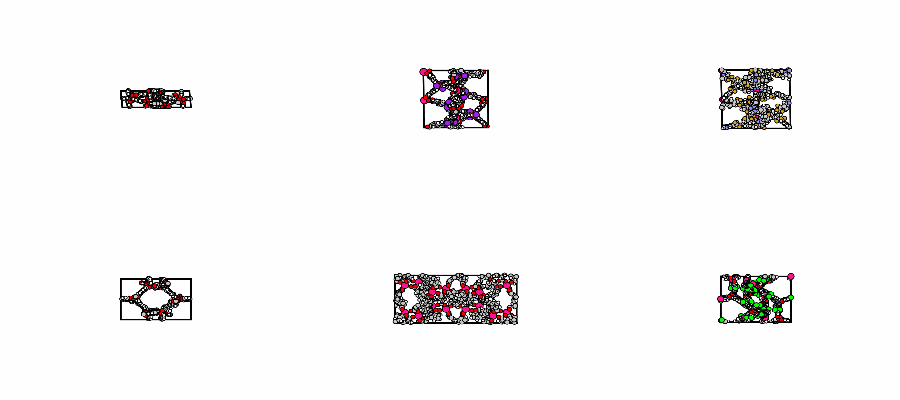

Please note that these structures have yet to be optimized


In [10]:
## This process might take 2~3 minutes
# Generate .gif of MOFs and visualize 
# Repository that gifs will be stored
mof_gif_dir = f'{save_dir}/mof_success_gif'

gif_dir = Path(mof_gif_dir)
gif_dir.mkdir(exist_ok=True)

# Generate gifs
make_concat_gif(cif_dir = mof_gen_success, gif_dir = mof_gif_dir)
display(ipy_image(f'{mof_gif_dir}/mof_concat.gif'))
cprint('Please note that these structures have yet to be optimized', 'cyan')